## Create water mask for later training the model
To generate the ground truth images we use the <code>create_gt</code> module. An example of the floodmap image retrieved for the flood in Sardinia, is shown. 

In [1]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

import numpy as np
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download
from src.data.copernicusEMS import activations
from rasterio.plot import show as rasterio_show

from src.data import create_gt
from src.data.utils import GCPPath, load_json_from_bucket


from src.data import create_gt
from rasterio import plot as rasterioplt
import numpy as np


import rasterio

%load_ext autoreload
%autoreload 2

In [2]:
temp = "ST_20170326_WaterExtent_OmusatiAndOshana0000000000-0000012544"
good = "EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a"
bad = "EMSR261_03WOLFSBURG_DEL_MONIT05_v2_observed_event_a"
ml_stage = "train"

# S2 IMAGE
filename = f"0_DEV/2_Mart/worldfloods_v2_0/{ml_stage}/S2/{bad}"
bucket_name= "ml4cc_data_lake"
s2_image_path = f"gs://{bucket_name}/{filename}.tif"

print(s2_image_path)

gs://ml4cc_data_lake/0_DEV/2_Mart/worldfloods_v2_0/train/S2/EMSR261_03WOLFSBURG_DEL_MONIT05_v2_observed_event_a.tif


(3761, 7387)


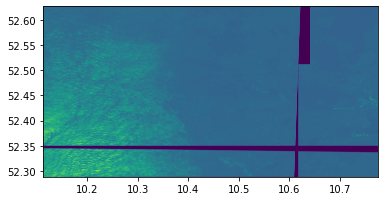

In [3]:


image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(s2_image_path) as src:
    print(src.shape)
#     image = src.read()
    transform = src.transform
    rasterioplt.show(src, transform=transform)

(3761, 7387)


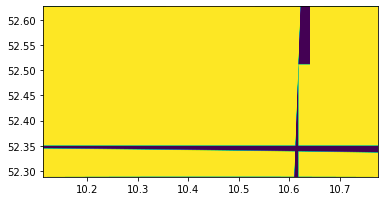

CPU times: user 1.4 s, sys: 85.4 ms, total: 1.49 s
Wall time: 2.26 s


In [5]:
%%time

# GT IMAGE
filename = f"0_DEV/2_Mart/worldfloods_v2_0/{ml_stage}/gt/{bad}"
bucket_name= "ml4cc_data_lake"
gt_image_path = f"gs://{bucket_name}/{filename}.tif"

with rasterio.open(gt_image_path) as src:
    print(src.shape)
    image = src.read(2)
    transform = src.transform
    rasterioplt.show(image, transform=transform)

In [6]:
np.unique(image)

array([0, 2], dtype=uint8)

In [8]:

# flood map
floodmap_geojson = "EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a.geojson"
filename = f"0_DEV/2_Mart/worldfloods_v2_0/{ml_stage}/floodmap/{bad}"
floodmap_geojson_path = f"gs://{bucket_name}/{filename}.shp"

# water_mask = create_gt.compute_water(image_name, floodmap, keep_streams=True)
filename = f"0_DEV/2_Mart/worldfloods_v2_0/{ml_stage}/meta/{bad}"
floodmap_meta_path = f"{filename}.json"
floodmap_meta = load_json_from_bucket(bucket_name, floodmap_meta_path)

# cloudprob
filename = f"0_DEV/2_Mart/worldfloods_v2_0/{ml_stage}/cloudprob/{bad}"
cloudprob_path = f"gs://{bucket_name}/{filename}.tif"

# permanent water = create_gt.compute_water(image_name, floodmap, keep_streams=True)
filename = f"worldfloods/tiffimages/PERMANENTWATERJRC/{bad}"
jrc_path = f"gs://{bucket_name}/{filename}.tif"


In [9]:
%%time

from src.data.create_gt import generate_water_cloud_binary_gt

gt, gt_meta = generate_water_cloud_binary_gt(
                        s2_image_path,
                        floodmap_geojson_path,
                        metadata_floodmap=floodmap_meta,
                        keep_streams=True,
                        cloudprob_image_path=cloudprob_path,
                        permanent_water_image_path=None,
                    )

CPU times: user 14.8 s, sys: 1.97 s, total: 16.8 s
Wall time: 39.1 s


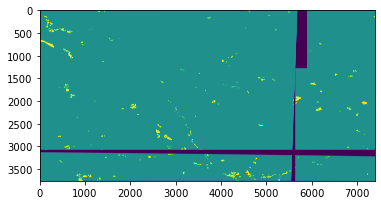

<AxesSubplot:>

In [12]:
rasterio_show(gt[1])

In [ ]:
%%time

from src.data.create_gt import generate_land_water_cloud_gt
gt, gt_meta = generate_land_water_cloud_gt(
                        s2_image_path,
                        floodmap_geojson_path,
                        keep_streams=True,
                        cloudprob_image_path=cloudprob_path,
                        permanent_water_image_path=None,
                    )

ERROR:fiona._env:Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


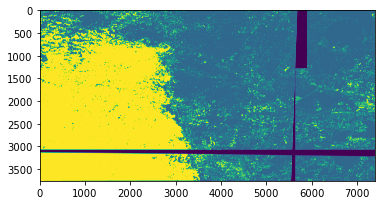

<AxesSubplot:>

### Old Bucket Data 


In [13]:

bucket_name = "ml4floods"

# S2 IMAGE
filename = f"worldfloods/public/{ml_stage}/S2/{bad}"
s2_image_path = f"gs://{bucket_name}/{filename}.tif"

floodmap_geojson = "EMSR286_08ITUANGONORTH_DEL_MONIT02_v1_observed_event_a.geojson"
filename = f"worldfloods/public/{ml_stage}/floodmaps/{bad}"
floodmap_geojson_path = f"gs://{bucket_name}/{filename}.shp"

# water_mask = create_gt.compute_water(image_name, floodmap, keep_streams=True)
filename = f"worldfloods/public/{ml_stage}/meta/{bad}"
floodmap_meta_path = f"{filename}.json"
floodmap_meta = load_json_from_bucket(bucket_name, floodmap_meta_path)

# water_mask = create_gt.compute_water(image_name, floodmap, keep_streams=True)
filename = f"worldfloods/tiffimages/cloudprob/{bad}"
cloudprob_path = f"gs://{bucket_name}/{filename}.tif"

# permanent water = create_gt.compute_water(image_name, floodmap, keep_streams=True)
filename = f"worldfloods/tiffimages/PERMANENTWATERJRC/{bad}"
jrc_path = f"gs://{bucket_name}/{filename}.tif"

In [14]:
%%time

from src.data.create_gt import generate_water_cloud_binary_gt

gt, gt_meta = generate_water_cloud_binary_gt(
                        s2_image_path,
                        floodmap_geojson_path,
                        metadata_floodmap=floodmap_meta,
                        keep_streams=True,
                        cloudprob_image_path=cloudprob_path,
                        permanent_water_image_path=None,
                    )

CPU times: user 15.2 s, sys: 1.32 s, total: 16.5 s
Wall time: 40.3 s


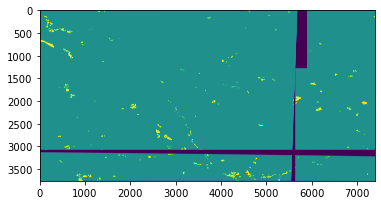

<AxesSubplot:>

In [15]:
rasterio_show(gt[1])

In [16]:
from src.data.io import save_groundtruth_tiff_rasterio

save_groundtruth_tiff_rasterio(
    gt,
    "./temp.tif",
    gt_meta=None,
    crs=gt_meta["crs"],
    transform=gt_meta["transform"],
)

(3761, 7387)


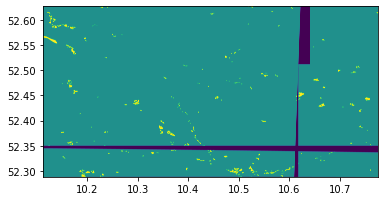

In [17]:
with rasterio.open("./temp.tif") as src:
    print(src.shape)
    image = src.read(2)
    transform = src.transform
    rasterioplt.show(image, transform=transform)

## Upload and then Load

In [18]:
from src.data.utils import save_file_to_bucket

save_file_to_bucket(
    gt_image_path, "./temp.tif"
)

(3761, 7387)


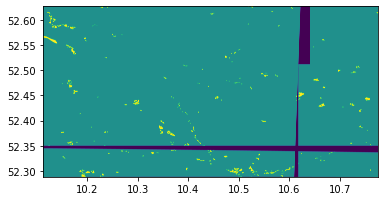

In [21]:
with rasterio.open(gt_image_path) as src:
    print(src.shape)
    image = src.read(2)
    transform = src.transform
    rasterioplt.show(image, transform=transform)

## After the Script

(3761, 7387)


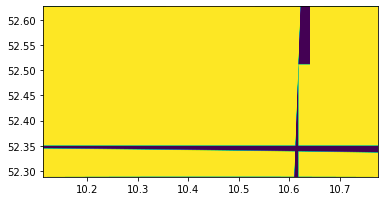

In [22]:
with rasterio.open(gt_image_path) as src:
    print(src.shape)
    image = src.read(2)
    transform = src.transform
    rasterioplt.show(image, transform=transform)